<a href="https://colab.research.google.com/github/cateto/python4NLP/blob/main/kobert/KoBert_news_classfication(%EC%A0%80%EC%9E%A5%EC%8B%A4%ED%8C%A8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# task : 뉴스 주제 분류 / BERT 계열 모델로는 89~90%까지 도달가능하다고 알려져 있음
!pip install transformers==3.5.0
!pip install tensorflow==2.3.0
!pip install torch==1.7.1
!pip install tensorflow_addons

  Using cached torch-1.7.1-cp37-cp37m-manylinux1_x86_64.whl (776.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu102 requires torch==1.9.0, but you have torch 1.7.1 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.1 which is incompatible.
     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [2]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
dataset = pd.read_csv('/content/drive/MyDrive/rsn_nlp_project/sample_0728.csv')

#라벨 데이터 category 정수로 변환

data_colname = 'contents'
label_colname = 'category'

encoder = LabelEncoder()
encoder.fit(dataset[label_colname])
dataset[label_colname] = encoder.transform(dataset[label_colname])


#이어서 contents 전처리(정제)
dataset[data_colname] = dataset[data_colname].str.replace("\(.*\)|\s-\s.*"," " ,regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("\[.*\]|\s-\s.*"," ",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("\<.*\>|\s-\s.*"," ",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("무단전재 및 재배포 금지"," ",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("무단 전재 및 재배포 금지"," ",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("©"," ",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("ⓒ"," ",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("저작권자"," ",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace(".* 기자", " ", regex=True) #기자 이름에서 오는 유사도 차단
dataset[data_colname] = dataset[data_colname].str.replace("사진 = .*", " ", regex=True) #사진 첨부 문구 삭제
dataset[data_colname] = dataset[data_colname].str.replace("사진=.*", " ", regex=True) #사진 첨부 문구 삭제
dataset[data_colname] = dataset[data_colname].str.replace('\"', "",regex=True)
dataset[data_colname] = dataset[data_colname].str.replace("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+.[a-zA-Z0-9-.]+)", " ", regex=True) #이메일 주소에서 오는 유사도 차단
dataset[data_colname] = dataset[data_colname].str.replace("\n"," ")
dataset[data_colname] = dataset[data_colname].str.replace("\r"," ")
dataset[data_colname] = dataset[data_colname].str.replace("\t"," ")
dataset[data_colname] = dataset[data_colname].str.replace( "\’" , "", regex=True)
# dataset[data_colname] = dataset[data_colname].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
dataset[data_colname] = dataset[data_colname].str.replace("[ ]{2,}"," ",regex=True)

dataset.head()

,id,contents,category
0,NIRW1900000029.1,부산 기관장들 국가사업 차질 없이 이뤄내겠다 부산CBS는 서병수 부산시장을 비롯한...,4
1,NIRW1900000029.2,"새해 해돋이 명소 등 트래픽 급증…이통3사, 비상태세 '이상無' 새해를 맞이해 통...",0
2,NIRW1900000029.3,조기 대선의 해…향배 가를 '5대 변수'는? 2017년 정유년 문재인' 연합의 단...,8
3,NIRW1900000029.4,달라지는 소비자제도..어린이운송차 속도제한장치 의무화 올해부터는 어린이 운송용 차...,3
4,NIRW1900000029.5,"광주 간 文, 전화 건 潘…대선주자들의 새해 첫날 지난 한해 정치권 비리로 너무 ...",8


In [4]:
mapping = dict(zip(range(len(encoder.classes_)), encoder.classes_))
mapping

{0: 'IT/과학',
 1: '경제',
 2: '문화',
 3: '미용/건강',
 4: '사회',
 5: '생활',
 6: '스포츠',
 7: '연예',
 8: '정치'}

일단 불용어, 메캅 안쓰고 kobert tokenizer로 테스트

In [5]:
# 로그가 너무 많이 떠서 colab이 멎는 현상이 있음
import logging
logging.basicConfig(level=logging.ERROR)

In [6]:
len(dataset)

128542

In [7]:
dataset = dataset[:50000] # colab gpu 제한

In [8]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [9]:
print('훈련용 data 개수 :',len(train)) # 훈련용 data 개수 출력
print('테스트용 data 개수 :',len(test)) # 테스트용 data 개수 출력

훈련용 data 개수 : 40000
테스트용 data 개수 : 10000


In [10]:
train.reset_index(drop=True, inplace=True) #중요!!!!
test.reset_index(drop=True, inplace=True) #중요!!!!

In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import urllib.request
import tensorflow_addons as tfa

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [12]:
import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [13]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

Downloading:   0%|          | 0.00/371k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

In [25]:
from tensorflow.keras.utils import to_categorical

def convert_data(data_df):
    global tokenizer
    
    SEQ_LEN = 128 #SEQ_LEN : 버트에 들어갈 인풋의 길이
    
    tokens, masks, segments, targets = [], [], [], []

    for i in tqdm(range(len(data_df))):
        # token : 문장을 토큰화함
       
        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, pad_to_max_length=True)

        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        pad_count = token.count(1)
        mask = [1]*(SEQ_LEN-pad_count) + [0]*pad_count
        
        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN

        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        # 정답(카테고리 9개)을 targets 변수에 저장해 줌
        targets.append(data_df[LABEL_COLUMN][i])

    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정    
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)
    targets = to_categorical(targets, num_classes=CLASS_NUM)

    return [tokens, masks, segments], targets

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    
    return data_x, data_y

SEQ_LEN = 128
BATCH_SIZE = 16
CLASS_NUM = 9 
# 긍부정 문장을 포함하고 있는 칼럼
DATA_COLUMN = "contents"
# 긍정인지 부정인지를 (1=긍정,0=부정) 포함하고 있는 칼럼
LABEL_COLUMN = "category"

In [26]:
train[:5]

,id,contents,category
0,NPRW1900000069.16460,"기보, 제주에서 청년·기술 창업교실 개최 기술보증기금이 ‘2017년 제2회 청년·...",1
1,NPRW1900000069.8266,"엠게임, '캐치몬' 쉼터 등록 이벤트 진행 엠게임은 증강현실 모바일게임 '캐치몬'...",0
2,NPRW1900000069.22651,"미래에셋자산운용, 전세계 4차산업 기업에 투자하는 ETF 출시 미래에셋자산운용은 ...",1
3,NIRW1900000030.7686,김정은 때문에 워커힐 호텔·남산타워 예약 불가? 김정은 북한 국무위원장의 연내 답...,5
4,NIRW1900000030.4941,'실행된 거래' 의혹 재판 주심…'임종헌 PC조사' 반대 대법관 사법농단 의혹과 ...,4


뉴스 기사의 최대 길이 :4528
뉴스 기사의 평균 길이 :838.564325


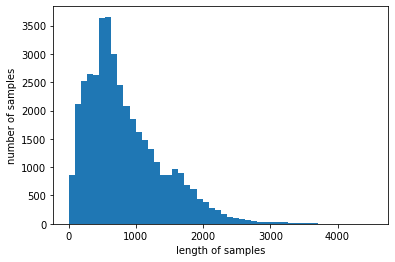

In [16]:
import matplotlib.pyplot as plt

print('뉴스 기사의 최대 길이 :{}'.format(max(len(l) for l in train[data_colname])))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, train[data_colname]))/len(train[data_colname])))

plt.hist([len(s) for s in train[data_colname]], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


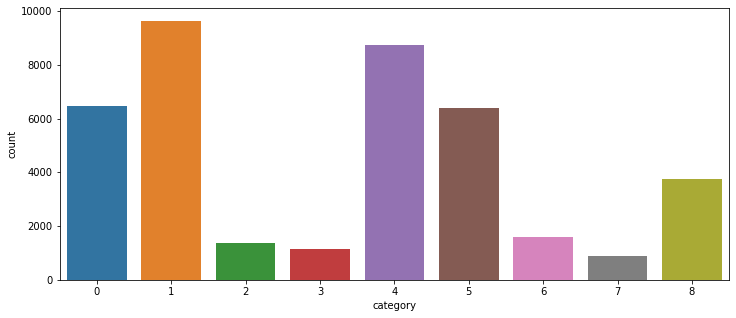

In [17]:
# 라벨 별 빈도수
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(train[label_colname])

In [27]:
# train 데이터를 버트 인풋에 맞게 변환
train_x, train_y = load_data(train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|          | 0/40000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

In [22]:
from tensorflow.keras.utils import to_categorical
temp_y = to_categorical(train_y, num_classes=9)

In [28]:
# 훈련 성능을 검증한 test 데이터를 버트 인풋에 맞게 변환
test_x, test_y = load_data(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

In [29]:
model = TFBertModel.from_pretrained("monologg/kobert", from_pt=True)
# 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
# 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/369M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [30]:
bert_outputs

(<tf.Tensor 'tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0' shape=(None, 128, 768) dtype=float32>,
 <tf.Tensor 'tf_bert_model/bert/pooler/dense/Tanh:0' shape=(None, 768) dtype=float32>)

- bert_outputs[0]은 모든 시점의 BERT의 최종 벡터. 문장 길이가 64일 경우에는 64 x 768
- bert_outputs[1]은 CLS 시점의 BERT의 벡터

In [31]:
bert_outputs = bert_outputs[1]

In [ ]:
# Rectified Adam 옵티마이저 사용
# 총 batch size * 4 epoch = 2344 * 4
# opt = tfa.optimizers.RectifiedAdam(lr=5.0e-5, total_steps = 2344*4, warmup_proportion=0.1, min_lr=1e-5, epsilon=1e-08, clipnorm=1.0)

In [32]:
from tensorflow.keras.optimizers import Adam

topic_drop = tf.keras.layers.Dropout(0)(bert_outputs)
topic_first = tf.keras.layers.Dense(9, activation='softmax')(topic_drop)
topic_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], topic_first)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
####
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
####

topic_model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics = ['accuracy'])

In [33]:
topic_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_segment (InputLayer)      [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 128, 768), ( 92186880    input_word_ids[0][0]             
                                                                 input_masks[0][0]     

In [34]:
topic_model.fit(train_x, train_y, epochs=4, shuffle=True, batch_size=16, callbacks=[es, mc], validation_data=(test_x, test_y))

Epoch 1/4
2500/2500 [==============================] - ETA: 0s - loss: 0.5241 - accuracy: 0.8272WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0105s vs `on_test_batch_end` time: 0.2442s). Check your callbacks.


2500/2500 [==============================] - 2041s 816ms/step - loss: 0.5241 - accuracy: 0.8272 - val_loss: 0.3653 - val_accuracy: 0.8722
Epoch 2/4
2500/2500 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.8995WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2500/2500 [==============================] - 2044s 818ms/step - loss: 0.2969 - accuracy: 0.8995 - val_loss: 0.3707 - val_accuracy: 0.8738
Epoch 3/4
2500/2500 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.9305WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2500/2500 [==============================] - 2039s 816ms/step - loss: 0.2073 - accuracy: 0.9305 - val_loss: 0.3919 - val_accuracy: 0.8763
Epoch 4/4
2500/2500 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.9539WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2500/2500 [==============================] - 2038s 815ms/step - loss: 0.1394 - accuracy: 0.9539 - val_loss: 0.4229 - val_accuracy: 0.8764


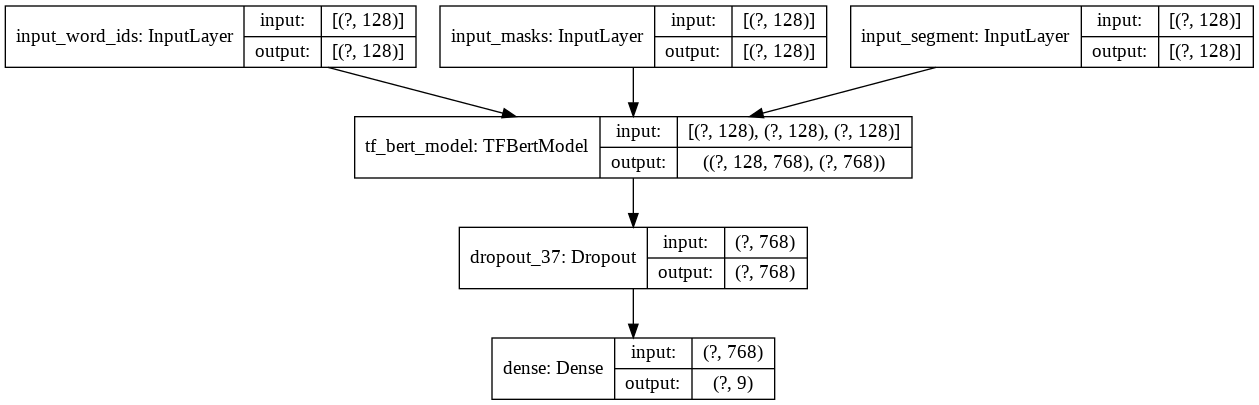

In [54]:
tf.keras.utils.plot_model(topic_model, "my_first_model.png", show_shapes=True)

In [71]:
model = topic_model

In [72]:
print(model)

In [82]:
import time

saved_model_path = "/content/drive/MyDrive/saved_models/{}".format(int(time.time()))

tf.saved_model.save(model, saved_model_path)
saved_model_path

ValueError: ignored